In [1]:
import cudf
import gc
import lightgbm as lgb
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
class LightGBMCollator(object):
    def __init__(self,dfs,features,label,k=12):
        self.dfs = dfs
        self.features = features
        self.label = label
        self.k = k
        
    def x_y_group(self,data,features,target,only_x=False,verbose=False):
        group = data.groupby('customer_id').size().to_frame('size')['size']
        data = data.sort_values('customer_id').reset_index()
        return data[features],data[target],group
        
    def get_train_dataset_by_index(self,index):
        trn_x,trn_y,trn_grp = self.x_y_group(self.dfs[index][0],features,label)
        return trn_x,trn_y,trn_grp
        
    def get_ground_truth_dataset_by_index(self,index):
        return self.dfs[index][-1]
    
    def get_test_dataset_by_index(self,index):
        return self.dfs[index][1]#.to_pandas()
    
    def construct_eval_dataset(self):
        self.gt_df = self.get_ground_truth_dataset_by_index(0)
        self.test_df = self.get_test_dataset_by_index(0)
    
    def evaluate_score(self,pred_df,gt_df,k=12,verbose=True,group_name='customer_id'):
        from metric import mapk
        eval_df = gt_df.merge(pred_df,on=group_name,how='left')
        score = mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist())
        if verbose: print('map@'+str(k),score)
        return score
    
    def feval(self,preds,eval_dataset):
        pred_df = pd.DataFrame()
        pred_df['customer_id'] = self.test_df['customer_id']
        pred_df['article_id'] = self.test_df['article_id']
        pred_df['prediction'] = preds
        pred_df = pred_df.groupby('customer_id') \
                        .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:self.k]) \
                        .reset_index()
        pred_df.columns = ['customer_id','prediction']
        score = self.evaluate_score(pred_df,self.gt_df,group_name='customer_id',verbose=False)
        return 'MAP@'+str(self.k), score, True

In [81]:
%%time
label = 'label'
#dataset_dir = 'storage/output/220325_dataset_2020-06-01_2020-08-01_2020-09-15_2020-09-22_sales-channel-habit/'
#dataset_dir = 'storage/output/220325_dataset_2020-06-01_2020-08-15_2020-09-15_2020-09-22/'
#dataset_dir = 'storage/output/220325_dataset_2020-06-01_2020-08-01_2020-09-15_2020-09-22_nweek0-ntotalitem100/'
dataset_dir = 'storage/output/220325_dataset_2020-06-01_2020-08-01_2020-09-15_2020-09-22/'
#dataset_dir = 'storage/output/220325_dataset_2020-05-24_2020-07-24_2020-09-07_2020-09-15/'
#dataset_dir = 'storage/output/220325_dataset_2020-05-17_2020-07-17_2020-09-01_2020-09-07/'

trn_df = pd.read_csv(os.path.join(dataset_dir,'trn_df.csv'))
test_df = pd.read_csv(os.path.join(dataset_dir,'test_df.csv'))
gt_df = pd.read_csv(os.path.join(dataset_dir,'gt_df.csv'))
gt_df['ground_truth'] = gt_df['ground_truth'].apply(eval)
print('Shape of constructed dataframe',trn_df.shape,test_df.shape,gt_df.shape)

Shape of constructed dataframe (27482671, 26) (5749835, 24) (68984, 2)
CPU times: user 48.2 s, sys: 6.99 s, total: 55.2 s
Wall time: 55.4 s


In [83]:
%%time
features = [c for c in trn_df.columns if c not in ['article_id','customer_id','customer_group','label','index','group_size']]
collator = LightGBMCollator([[trn_df,test_df,gt_df]],features,label)
trn_x,trn_y,trn_grp = collator.get_train_dataset_by_index(0)
collator.construct_eval_dataset()

trn_dataset = lgb.Dataset(trn_x,trn_y,group=trn_grp)
val_dataset = lgb.Dataset(collator.test_df[collator.features])

CPU times: user 23.1 s, sys: 5.15 s, total: 28.2 s
Wall time: 28.2 s


In [84]:
%%time
param = dict(
    objective='lambdarank',
    metric='map@12',
    boosting='dart',
    num_round = 15,
    seed=0,
    learning_rate=0.03,
    num_threads=8,
)
bst = lgb.train(
    param,
    trn_dataset,
    feval=collator.feval,
    valid_sets=[val_dataset],
)

/home/kinho.lo/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.542295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4397
[LightGBM] [Info] Number of data points in the train set: 27482671, number of used features: 22
[1]	valid_0's MAP@12: 0.0206098
[2]	valid_0's MAP@12: 0.0213825
[3]	valid_0's MAP@12: 0.021932
[4]	valid_0's MAP@12: 0.0221653
[5]	valid_0's MAP@12: 0.0227604
[6]	valid_0's MAP@12: 0.0228595
[7]	valid_0's MAP@12: 0.0228853
[8]	valid_0's MAP@12: 0.0228618
[9]	valid_0's MAP@12: 0.0228171
[10]	valid_0's MAP@12: 0.0230357
[11]	valid_0's MAP@12: 0.0229132
[12]	valid_0's MAP@12: 0.0230362
[13]	valid_0's MAP@12: 0.0232484
[14]	valid_0's MAP@12: 0.0230117
[15]	valid_0's MAP@12: 0.0230033
CPU times: user 6min 16s, sys: 8.36 s, total: 6min 25s
Wall time: 4min 18s


In [77]:
score = 0.022701

In [78]:
def file_str(dataset,score,param):
    s = '_'.join([dataset,'score:'+str(score)]+[str(k)+':'+str(v) for k,v in param.items()])
    return s

In [79]:
out_dir = 'storage/output/220325_lightgbm_training/'

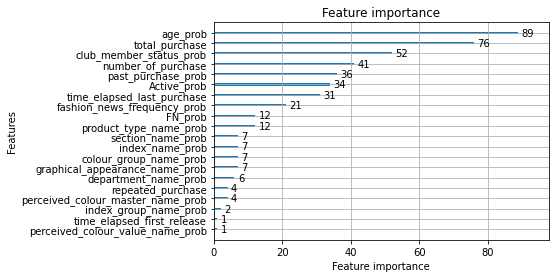

In [80]:
os.makedirs(out_dir,exist_ok=True)
filename = file_str(os.path.dirname(dataset_dir).split('/')[-1],score,bst.params)
fig = lgb.plot_importance(bst)
fig.get_figure().savefig(os.path.join(out_dir,filename+'.png'))
bst.save_model(os.path.join(out_dir,filename+'.bin'))

In [95]:
def evaluate_score(pred_df,gt_df,k=12,verbose=True,group_name='customer_id'):
    from metric import mapk
    eval_df = gt_df.merge(pred_df,on=group_name,how='left')
    score = mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist())
    if verbose: print('map@'+str(k),score)
    return score

def feval(model,test_df,k=12):
    test_x = test_df[features]
    preds = model.predict(test_x)
    pred_df = pd.DataFrame()
    pred_df['customer_id'] = test_df['customer_id']
    pred_df['article_id'] = test_df['article_id']
    pred_df['prediction'] = preds
    pred_df = pred_df.groupby('customer_id') \
                    .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:k]) \
                    .reset_index()
    pred_df.columns = ['customer_id','prediction']
    print(pred_df)
    score = evaluate_score(pred_df,gt_df,group_name='customer_id',verbose=False)
    return 'MAP@'+str(k), score, True

In [96]:
feval(bst,test_df)

                                             customer_id  \
0      00039306476aaf41a07fed942884f16b30abfa83a2a8be...   
1      0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...   
2      000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   
3      000525e3fe01600d717da8423643a8303390a055c578ed...   
4      00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...   
...                                                  ...   
68979  fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82b...   
68980  fffa7d7799eb390a76308454cbdd76e473d65b1497fbe4...   
68981  fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...   
68982  fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...   
68983  fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...   

                                              prediction  
0      [448509014, 850917001, 852584001, 863595006, 9...  
1      [889036004, 880017001, 640021012, 621381012, 9...  
2      [556255001, 816588001, 399136061, 732842015, 7...  
3      [448509014, 850917001, 863595006, 91

('MAP@12', 0.02300326629219794, True)